In [ ]:

# Install required libraries
!pip install numpy pandas scikit-learn tensorflow keras yfinance matplotlib seaborn


The main

In [ ]:
import os
import warnings
import yfinance as yf
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Suppress warnings to clean up output
warnings.filterwarnings("ignore")

# Stock Ticker Lists
NIFTY50_TICKERS = [
    'ADANIENT.ns', 'ADANIPORTS.ns', 'APOLLOHOSP.ns', 'ASIANPAINT.ns', 
    'AXISBANK.ns', 'BAJAJ-AUTO.ns', 'BAJFINANCE.ns', 'BAJAJFINSV.ns', 
    # ... (rest of Nifty 50 tickers)
]

SP500_TICKERS = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "META", 
    # ... (rest of S&P 500 tickers)
]

# Configuration Parameters
START_DATE = '2022-07-26'
END_DATE = '2024-07-28'
PREDICTIONS_FOLDER = 'predictions'

def create_predictions_directory():
    """Create predictions directory if it doesn't exist."""
    if not os.path.exists(PREDICTIONS_FOLDER):
        os.makedirs(PREDICTIONS_FOLDER)

def initialize_csv_file(file_name):
    """Initialize a CSV file with standard prediction columns."""
    columns = ['Date', 'Name', 'Act', 'Pred_LR', 'Pred_RF', 'Pred_SVR', 'Pred_LSTM']
    df = pd.DataFrame(columns=columns)
    df.to_csv(file_name, index=False)

def append_prediction_to_csv(file_name, row_data):
    """Append a new prediction row to the CSV file."""
    if not os.path.exists(file_name):
        initialize_csv_file(file_name)
    
    df = pd.read_csv(file_name)
    df.loc[len(df)] = row_data
    df.to_csv(file_name, index=False)

def download_stock_data(tickers, start_date, end_date):
    """Download historical stock data for given tickers."""
    for ticker in tickers:
        file_name = f"data/{ticker}_historical_data.csv"
        print(f"Downloading data for {ticker}", end='\r')
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        stock_data.to_csv(file_name)
        print(f"Data for {ticker} saved to {file_name}")

def train_lstm_model(X, y):
    """Train an LSTM model for stock price prediction."""
    model_lstm = Sequential([
        LSTM(units=64, input_shape=(X.shape[1], 1)),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    model_lstm.fit(X.reshape(len(X), X.shape[1], 1), y, epochs=50, batch_size=32, verbose=0)
    return model_lstm

def predict_with_lstm(model, X_np):
    """Make a prediction using the trained LSTM model."""
    return model.predict(X_np.reshape(1, X_np.shape[0], 1), verbose=0)[0][0]

def prepare_stock_predictions():
    """Main function to generate stock predictions using multiple models."""
    create_predictions_directory()
    
    #unique symbols
    symbols = list(set(NIFTY50_TICKERS))
    
    for ticker in symbols:
        print(ticker, end='\r')
        file_name = f"data/{ticker}_historical_data.csv"
        df = pd.read_csv(file_name)
        
        if '2023-07-25' in list(df['Date']):
            idx_start = df.index[df['Date'] == '2023-07-25'].tolist()[0]
            
            # Compute initial LSTM model
            initial_df = df.iloc[:idx_start]
            initial_X = initial_df[['Open', 'High', 'Low', 'Close', 'Volume']]
            initial_y = (((initial_df['Low'] - initial_df['Open']) / initial_df['Open']) * 100).shift(-1)
            
            model_lstm = train_lstm_model(initial_X.values, initial_y[:idx_start].values)
            
            # Predict for each subsequent date
            for j in range(idx_start, len(df)):
                current_df = pd.read_csv(file_name)
                date = current_df['Date'].iloc[j]
                current_df['y'] = (((current_df['Low'] - current_df['Open']) / current_df['Open']) * 100).shift(-1)

                y = current_df['y']
                X_data = current_df[['Open', 'High', 'Low', 'Close', 'Volume']]
                
                X_train = X_data.iloc[:j]
                x_current = X_data.iloc[j]
                actual_value = y.iloc[j]
                
                # Train and predict with multiple models
                model_lr = LinearRegression().fit(X_train, y[:j])
                pred_lr = model_lr.predict([x_current])[0]
                
                model_rf = RandomForestRegressor(n_estimators=100).fit(X_train, y[:j])
                pred_rf = model_rf.predict([x_current])[0]
                
                model_svr = SVR(kernel='rbf').fit(X_train, y[:j])
                pred_svr = model_svr.predict([x_current])[0]
                
                pred_lstm = predict_with_lstm(model_lstm, x_current.values)
                
                # Prepare and save results
                results = [date, ticker, actual_value, pred_lr, pred_rf, pred_svr, pred_lstm]
                date_file_name = os.path.join(PREDICTIONS_FOLDER, f"{date}_predictions_nifty50.csv")
                append_prediction_to_csv(date_file_name, results)

if __name__ == "__main__":
    prepare_stock_predictions()

SyntaxError: invalid syntax (3391310316.py, line 73)

Backtester

Loading 508 daily files...
Loaded data from 2023-07-25 to 2024-07-26


FINAL PERFORMANCE REPORT
           Total Return %  Win Rate %  Sharpe Ratio  Max Drawdown %
Model                                                              
Pred_LR            190.65       70.61          7.17           -5.86
Pred_RF             87.18       62.21          3.99           -8.66
Pred_SVR           184.89       70.23          7.01           -5.85
Pred_LSTM           22.99       54.20          1.34          -15.09



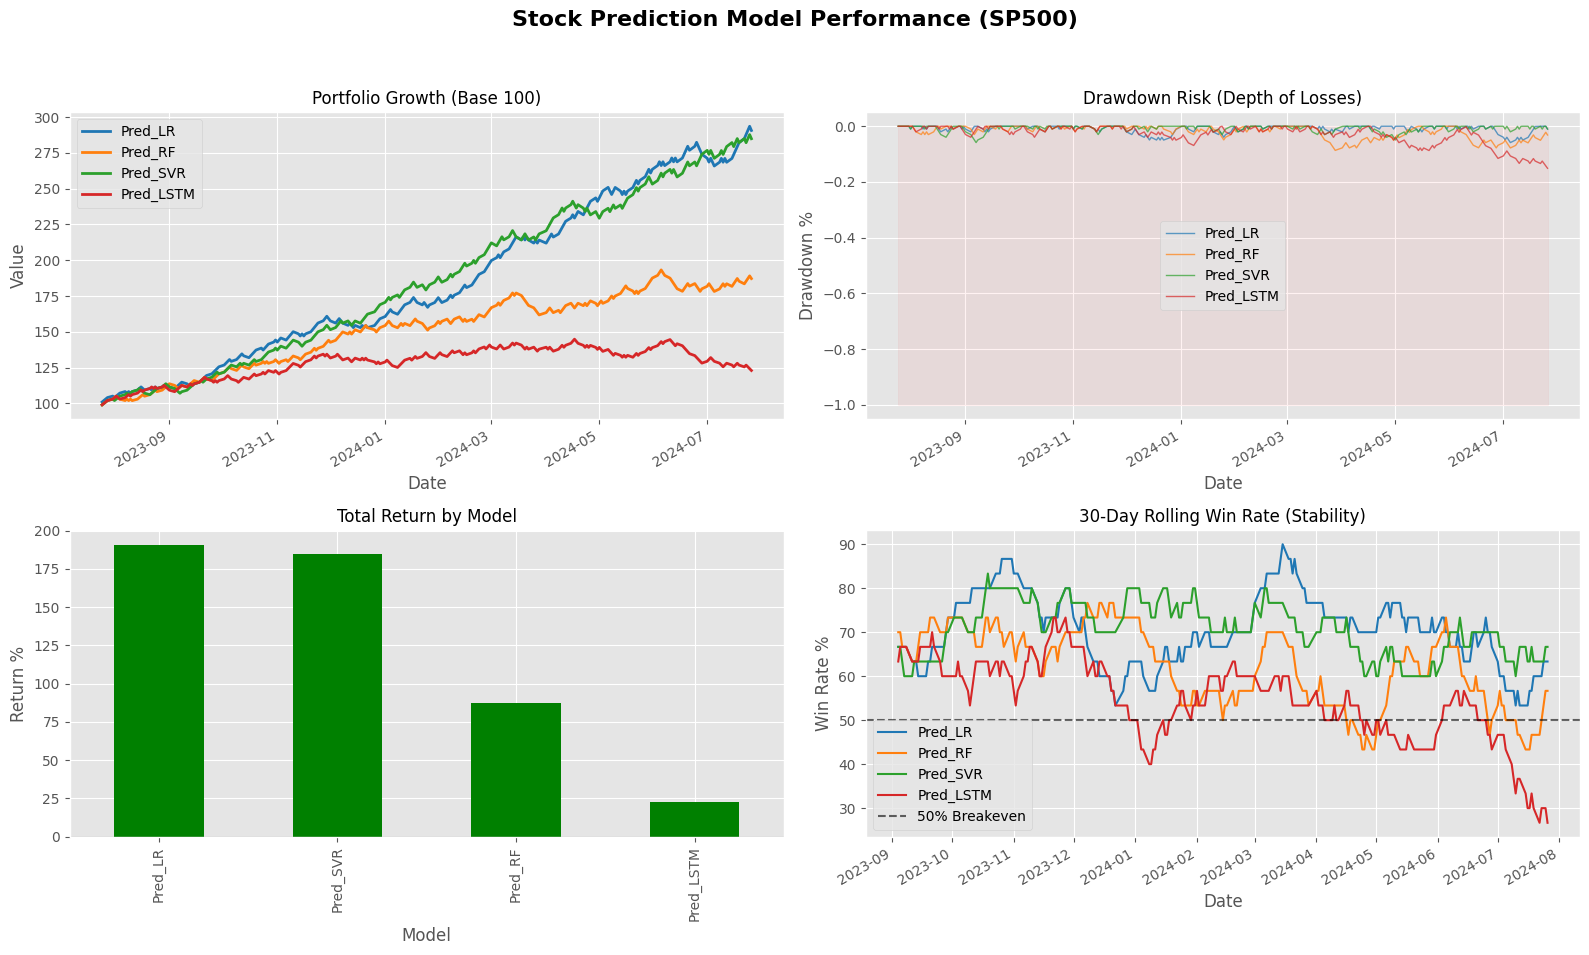

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("tab10")

class ModelBacktester:
    def __init__(self, predictions_folder="predictions"):
        self.predictions_folder = predictions_folder
        self.results_df = None
        self.daily_returns = pd.DataFrame()
        self.metrics = {}

    def load_data(self):
        """Loads and aggregates all prediction files."""
        all_data = []
        files = [f for f in os.listdir(self.predictions_folder) if f.endswith('.csv')]
        
        if not files:
            raise FileNotFoundError(f"No CSV files found in {self.predictions_folder}")

        print(f"Loading {len(files)} daily files...")
        
        for file in files:
            try:
                # Extract date from filename (2023-07-25_predictions...)
                date_str = file.split('_')[0]
                df = pd.read_csv(os.path.join(self.predictions_folder, file))
                df['Date'] = pd.to_datetime(date_str)
                all_data.append(df)
            except Exception as e:
                print(f"Error reading {file}: {e}")

        if not all_data:
            raise ValueError("No valid data found.")

        self.results_df = pd.concat(all_data, ignore_index=True)
        self.results_df = self.results_df.sort_values('Date')
        print(f"Loaded data from {self.results_df['Date'].min().date()} to {self.results_df['Date'].max().date()}\n")

    def simulate_strategy(self, models=['Pred_LR', 'Pred_RF', 'Pred_SVR', 'Pred_LSTM']):
        """
        Strategy: Short the stock with the lowest predicted value.
        If Actual drop > 1%, we win +1%. Else we lose -1%.
        """
        model_returns_list = []
        dates = self.results_df['Date'].unique()
        
        # Pre-calculate to avoid loop slowness
        for date in dates:
            day_data = self.results_df[self.results_df['Date'] == date]
            row = {'Date': date}
            
            for model in models:
                # Find the stock the model thinks will drop the most
                if not day_data.empty:
                    # Sort by prediction (lowest first)
                    top_pick = day_data.sort_values(by=model, ascending=True).iloc[0]
                    
                    # Logic: Fixed 1% Win or Loss
                    if top_pick['Act'] <= -1.0:
                        row[model] = 0.01
                    else:
                        row[model] = -0.01
                else:
                    row[model] = 0.0
            
            model_returns_list.append(row)

        self.daily_returns = pd.DataFrame(model_returns_list).set_index('Date').sort_index()

    def calculate_metrics(self):
        """Calculates Sharpe, Sortino, Win Rate, etc."""
        summary = []
        
        for col in self.daily_returns.columns:
            rets = self.daily_returns[col]
            
            # Annualized Return (Approximate)
            total_return = ((1 + rets).prod() - 1) * 100
            
            # Win Rate
            wins = rets[rets > 0].count()
            total = rets[rets != 0].count()
            win_rate = (wins / total * 100) if total > 0 else 0
            
            # Sharpe Ratio (assuming 0% risk free)
            # Annualized by sqrt(252)
            mean = rets.mean()
            std = rets.std()
            sharpe = (mean / std) * np.sqrt(252) if std != 0 else 0
            
            # Max Drawdown
            cum_ret = (1 + rets).cumprod()
            peak = cum_ret.cummax()
            drawdown = (cum_ret - peak) / peak
            max_dd = drawdown.min() * 100
            
            summary.append({
                'Model': col,
                'Total Return %': total_return,
                'Win Rate %': win_rate,
                'Sharpe Ratio': sharpe,
                'Max Drawdown %': max_dd
            })
            
        self.metrics = pd.DataFrame(summary).set_index('Model')
        return self.metrics

    def plot_performance(self):
        """Generates the dashboard."""
        
        # 1. Equity Curve Data
        cum_returns = (1 + self.daily_returns).cumprod() * 100
        
        # 2. Drawdown Data
        drawdown = (cum_returns / cum_returns.cummax()) - 1
        
        # 3. Rolling Win Rate Data (Window = 30 Days)
        # Convert returns to 1 (win) or 0 (loss/tie)
        binary_wins = (self.daily_returns > 0).astype(int)
        rolling_win_rate = binary_wins.rolling(window=30).mean() * 100

        # --- PLOTTING ---
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Stock Prediction Model Performance (SP500)', fontsize=16, weight='bold')

        # Plot A: Equity Curve
        cum_returns.plot(ax=axes[0, 0], linewidth=2)
        axes[0, 0].set_title('Portfolio Growth (Base 100)', fontsize=12)
        axes[0, 0].set_ylabel('Value')
        axes[0, 0].legend(loc='upper left')

        # Plot B: Drawdown
        drawdown.plot(ax=axes[0, 1], linewidth=1, alpha=0.7)
        axes[0, 1].fill_between(drawdown.index, 0, -1, color='red', alpha=0.05)
        axes[0, 1].set_title('Drawdown Risk (Depth of Losses)', fontsize=12)
        axes[0, 1].set_ylabel('Drawdown %')

        # Plot C: Total Return Bar Chart
        metrics_sorted = self.metrics['Total Return %'].sort_values(ascending=False)
        colors = ['green' if x > 0 else 'red' for x in metrics_sorted.values]
        metrics_sorted.plot(kind='bar', ax=axes[1, 0], color=colors)
        axes[1, 0].set_title('Total Return by Model', fontsize=12)
        axes[1, 0].set_ylabel('Return %')
        axes[1, 0].axhline(0, color='black', linewidth=0.8)

        # Plot D: Rolling Win Rate (The Replacement for Distribution)
        rolling_win_rate.plot(ax=axes[1, 1], linewidth=1.5)
        axes[1, 1].set_title('30-Day Rolling Win Rate (Stability)', fontsize=12)
        axes[1, 1].set_ylabel('Win Rate %')
        axes[1, 1].axhline(50, linestyle='--', color='black', alpha=0.6, label='50% Breakeven')
        axes[1, 1].legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

if __name__ == "__main__":
    analyzer = ModelBacktester("predictions")
    analyzer.load_data()
    analyzer.simulate_strategy()
    
    metrics = analyzer.calculate_metrics()
    
    print("\n" + "="*50)
    print("FINAL PERFORMANCE REPORT")
    print("="*50)
    print(metrics.round(2))
    print("="*50 + "\n")
    
    analyzer.plot_performance()